GRAPH EMBEDDINGS

Read graph, display degree distribution and perform normality test

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


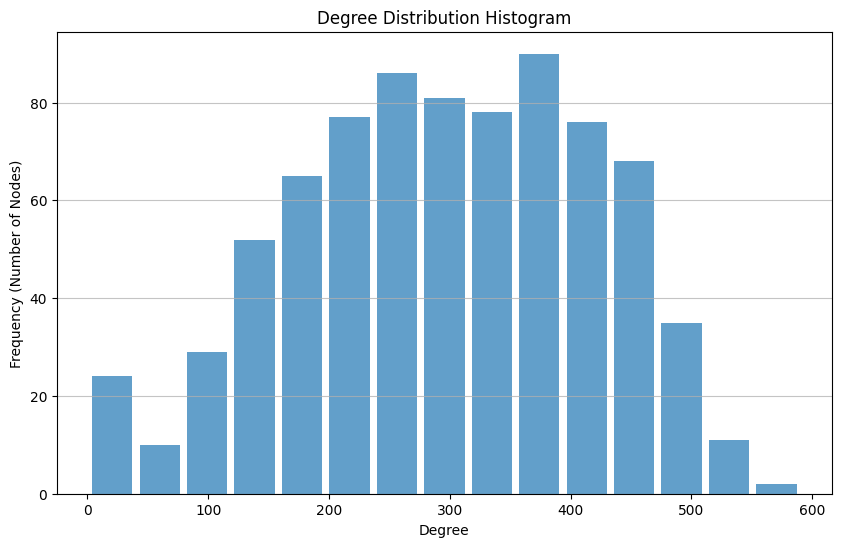

In [2]:

G = nx.read_gexf('monthly_graphs/graph_2018_month07.gexf')

# --- Step 2: Calculate Node Degrees ---
degrees = [G.degree(n) for n in G.nodes()]

# --- Step 3: Plot the Histogram ---
plt.figure(figsize=(10, 6))
# The `bins` parameter can be an integer or 'auto' to let matplotlib decide
plt.hist(degrees, bins='auto', alpha=0.7, rwidth=0.85)

plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency (Number of Nodes)")
plt.grid(axis='y', alpha=0.75)
plt.show()

Shapiro-Wilk Test Statistic: 0.9841810703861722
P-value: 1.7313632695214914e-07
The data does not appear to be normally distributed (reject H0).


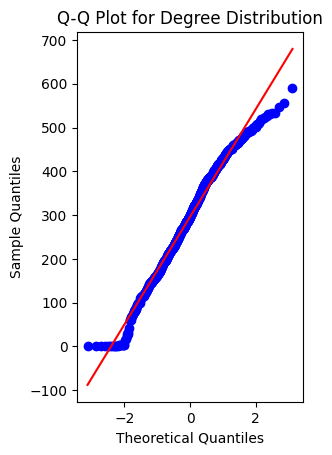

In [3]:
# --- Step 3: Perform Normality Testing and Plot ---
# Perform the Shapiro-Wilk test for normality on the degrees
if len(degrees) > 2:
    shapiro_statistic, shapiro_p_value = stats.shapiro(degrees)
    print(f"Shapiro-Wilk Test Statistic: {shapiro_statistic}")
    print(f"P-value: {shapiro_p_value}")
    if shapiro_p_value > 0.05:
        print("The data appears to be normally distributed (fail to reject H0).")
    else:
        print("The data does not appear to be normally distributed (reject H0).")
else:
    print("Not enough data points to perform Shapiro-Wilk test.")


# Generate and display the Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(degrees, dist="norm", plot=plt)
plt.title("Q-Q Plot for Degree Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Show the plots
plt.show()

Create vector representation of node using node2vec

In [4]:
# --- Step 2: Generate Embeddings with Node2Vec ---

# The Node2Vec constructor takes the graph, dimensions of the embeddings,
# and parameters for the random walks.
# walk_length: How many nodes are in each random walk.
# num_walks: How many random walks to start from each node.
# workers: Number of parallel threads to use.
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model to generate the embeddings.
# This may take a few minutes depending on the size of your graph.
# 'window' is the context size for the underlying Word2Vec model.
# 'min_count=1' ensures all nodes are embedded.
model = node2vec.fit(window=10, min_count=1, batch_words=4)
print("Node2Vec model training complete.")

# The embeddings are stored in a KeyedVectors object (part of gensim)
# We can access the vector for a specific node like this:
# vector_for_node_A = model.wv['station_id_A']

# Get all node names (station IDs) and their corresponding vectors
nodes = list(G.nodes())
embedding_vectors = [model.wv[node] for node in nodes]


Computing transition probabilities: 100%|██████████| 784/784 [02:35<00:00,  5.05it/s]


Node2Vec model training complete.


Clustering complete.


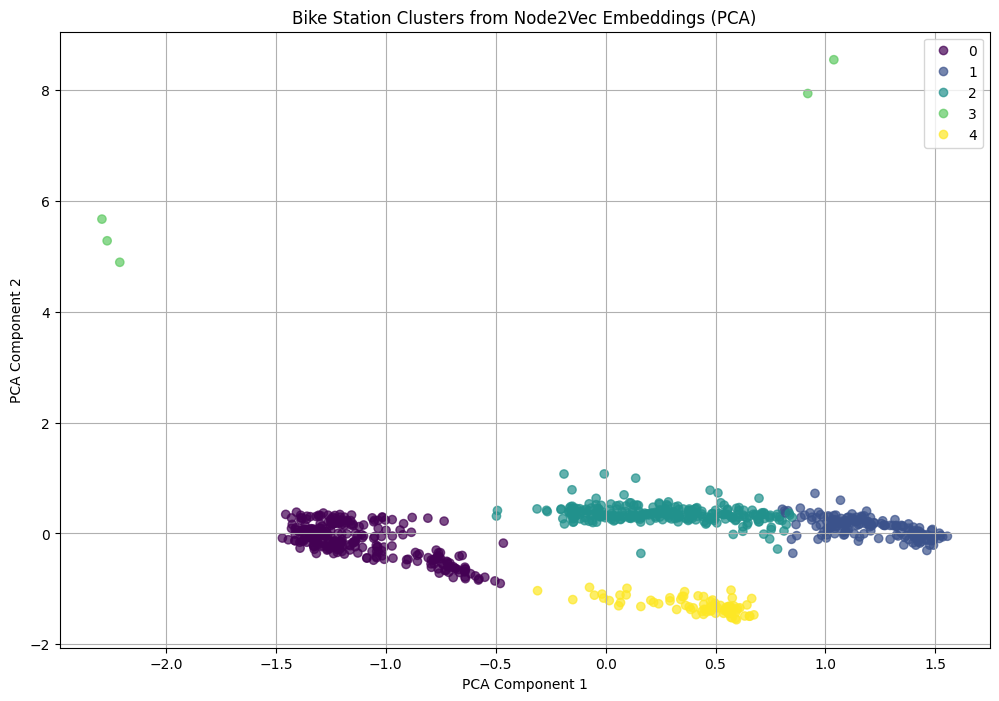


--- Analysis of Station Clusters ---

Cluster 0 contains 267 stations.
Sample stations: ['460.0', '3093.0', '3086.0', '3430.0', '2002.0']

Cluster 1 contains 166 stations.
Sample stations: ['2006.0', '281.0', '3282.0', '3165.0', '3137.0']

Cluster 2 contains 264 stations.
Sample stations: ['426.0', '514.0', '3256.0', '432.0', '3263.0']

Cluster 3 contains 5 stations.
Sample stations: ['3254.0', '3479.0', '3182.0', '3036.0', '3488.0']

Cluster 4 contains 82 stations.
Sample stations: ['3118.0', '3119.0', '3124.0', '3526.0', '3532.0']


In [7]:
# --- Step 3: Analyze the Embeddings with Clustering ---

# 1. Cluster the embeddings using K-Means to find groups of similar stations
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embedding_vectors)
print("Clustering complete.")

# 2. Use PCA to reduce the embedding dimensions for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_vectors)

# 3. Visualize the clustered embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title('Bike Station Clusters from Node2Vec Embeddings (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(5))
plt.grid(True)
plt.show()


# --- Step 4: Inspect the Clusters ---
results = pd.DataFrame({'station_id': nodes, 'cluster': clusters})

print("\n--- Analysis of Station Clusters ---")
for i in range(5):
    cluster_nodes = results[results['cluster'] == i]['station_id'].tolist()
    print(f"\nCluster {i} contains {len(cluster_nodes)} stations.")
    print(f"Sample stations: {cluster_nodes[:5]}") # Uncomment to view some station IDs in the cluster


Calculate traditional centrality scores and find highest average scores

In [8]:
# --- Step 1: Calculate Centrality Scores for Every Node ---

# Degree Centrality: Measures the number of connections a node has.
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality: Measures how often a node lies on the shortest path between other nodes.
# This is a great indicator of a "bridge" node. It's computationally intensive.
betweenness_centrality = nx.betweenness_centrality(G)

print("Calculated degree and betweenness centrality.")

# --- Step 2: Add these scores to your results DataFrame ---

# The centrality functions return dictionaries. We'll map them to our DataFrame.
results['degree_centrality'] = results['station_id'].map(degree_centrality)
results['betweenness_centrality'] = results['station_id'].map(betweenness_centrality)


# --- Step 3: Find the Most Central *Cluster* ---

# Now, we group by cluster and find the average centrality for each group.
cluster_analysis = results.groupby('cluster').agg({
    'degree_centrality': 'mean',
    'betweenness_centrality': 'mean',
    'station_id': 'count'  # See how many stations are in each cluster
}).rename(columns={'station_id': 'station_count'})

# Sort the clusters by their average centrality to find the most important ones.
# A high betweenness centrality is a strong sign of a central "bridge" cluster.
sorted_clusters = cluster_analysis.sort_values(by='betweenness_centrality', ascending=False)

print("\n--- Centrality Analysis by Cluster ---")
print(sorted_clusters)


# --- Step 4: Identify the Central Nodes ---

# The cluster at the top of the sorted list is your most central cluster.
# The nodes within that cluster are your central nodes.
central_cluster_id = sorted_clusters.index[0]
central_nodes = results[results['cluster'] == central_cluster_id]

print(f"\nCluster {central_cluster_id} is the most central.")
print("It contains nodes with the highest average betweenness centrality.")
print("\nTop 5 central stations in this cluster (by degree centrality):")
print(central_nodes.sort_values(by='degree_centrality', ascending=False).head())


Calculated degree and betweenness centrality.

--- Centrality Analysis by Cluster ---
         degree_centrality  betweenness_centrality  station_count
cluster                                                          
2                 0.495172                0.001357            264
0                 0.339336                0.000629            267
1                 0.351575                0.000481            166
4                 0.198875                0.000426             82
3                 0.019923                0.000007              5

Cluster 2 is the most central.
It contains nodes with the highest average betweenness centrality.

Top 5 central stations in this cluster (by degree centrality):
    station_id  cluster  degree_centrality  betweenness_centrality
24       519.0        2           0.753512                0.005944
111      497.0        2           0.708812                0.004090
145      265.0        2           0.699872                0.003749
90       402.0       

In [9]:
# --- Find the Most Central Node in Each Cluster ---

# The .loc and .idxmax() methods are perfect for this.
# .idxmax() finds the index of the first occurrence of the maximum value.
# We then use .loc to select that entire row.
most_central_nodes = results.loc[results.groupby('cluster')['betweenness_centrality'].idxmax()]

print("\\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---")
print(most_central_nodes)

# If you prefer to find the most connected node (highest degree) instead:
most_connected_nodes = results.loc[results.groupby('cluster')['degree_centrality'].idxmax()]

print("\n\n--- Most Connected Node in Each Cluster (based on Degree Centrality) ---")
print(most_connected_nodes)

\n--- Most Central Node in Each Cluster (based on Betweenness Centrality) ---
    station_id  cluster  degree_centrality  betweenness_centrality
40      3016.0        0           0.680715                0.006725
155      457.0        1           0.577267                0.003727
24       519.0        2           0.753512                0.005944
0       3254.0        3           0.040868                0.000016
369     3129.0        4           0.573436                0.003429


--- Most Connected Node in Each Cluster (based on Degree Centrality) ---
    station_id  cluster  degree_centrality  betweenness_centrality
40      3016.0        0           0.680715                0.006725
101     3142.0        1           0.651341                0.003631
24       519.0        2           0.753512                0.005944
0       3254.0        3           0.040868                0.000016
369     3129.0        4           0.573436                0.003429
